#  Visualizing Adoption and Return Trends in Sonoma Animal Data
03/15/2024

#### Rafael L.S. Reis, Dalia Cabrera Hurtado, Gabe Myers

## Introduction
The Sonoma Animal Shelter dataset, provided by the County of Sonoma Department of Health Services, comprises about 30,000 records detailing various attributes of animals admitted to the shelter. Each record includes species, breed, age, sex, and color, along with intake and outcome types to track the animals journey in the shelter. With over 4,000 animals entering the shelter annually, the dataset offers insights into adoption trends, shelter capacity, and animal welfare efforts. It gets updated regularly with the most recent being March 18, 2025.

This analysis seeks to answer two key questions: first, how does the number of days an animal spends in the shelter differ between those that are adopted and those that are returned to their owners; and second, is there an association between an animal's primary coat color—extracted from compound color entries—and its outcome or duration of shelter stay.

note: This is tentative and we will likely hone down our scope of questionings(likely to colors)

data downloaded from:
https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-15-october-2024.csv

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime # for age stuff

## Initial Data Exploration

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-17-march-2025.csv')

## Data preprocessing

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30027 entries, 0 to 30026
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  22171 non-null  object 
 1   Type                  30027 non-null  object 
 2   Breed                 30027 non-null  object 
 3   Color                 30027 non-null  object 
 4   Sex                   30027 non-null  object 
 5   Size                  29991 non-null  object 
 6   Date Of Birth         22736 non-null  object 
 7   Impound Number        30027 non-null  object 
 8   Kennel Number         30019 non-null  object 
 9   Animal ID             30027 non-null  object 
 10  Intake Date           30027 non-null  object 
 11  Outcome Date          29906 non-null  object 
 12  Days in Shelter       30027 non-null  int64  
 13  Intake Type           30027 non-null  object 
 14  Intake Subtype        30027 non-null  object 
 15  Outcome Type       

In [15]:
df.sample(5)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
16970,ZUES,DOG,CATAHOULA/MIX,TAN/WHITE,Male,LARGE,03/16/2020,K22-040911,DQ109,A410552,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_PRVS,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.4716444, -122.7398255)",1
2560,*PUMPKIN,OTHER,RABBIT LH,WHITE/ORANGE,Male,SMALL,09/17/2022,K24-049701,CA01,A428899,...,FLD_STRAY,TRANSFER,NAPA BUNS,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,94559.0,"94559(38.29911, -122.28541)",1
5739,WILLIE,CAT,DOMESTIC SH,WHITE/BLACK,Neutered,SMALL,05/22/2016,K16-021278,CA02,A344149,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,COUNTY,SANTA ROSA,NaN,NaN,1
17349,BISCUIT,DOG,BOXER,BROWN/WHITE,Female,MED,NaN,K15-015813,DS80,A326651,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_IDTAG,HEALTHY,HEALTHY,SANTA ROSA,OUT OF COUNTY,95449.0,"95449(38.9754474, -123.0939431)",1
22627,*GIDGIT,DOG,CAIRN TERRIER,WHITE/TAN,Spayed,SMALL,12/29/2011,K14-012064,DA02,A314873,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.4716444, -122.7398255)",1


Among dogs returned to their owners, which coat colors are most frequently associated with being lost or having escaped? To try explore this, we can create a simplified color category column to analyze color hues effectively.

Below are the functions to help create a new column to get the color shade of the animals

Function to clean and normalize breeds

### Functions and expressions to pre-process data

In [16]:
# Function to extract primary breed
def get_primary_breed(breed_string):
    if pd.isna(breed_string):
        return "Unknown"
    
    breed_string = str(breed_string).strip()
    
    # For breeds with "MIX" or similar suffix
    if 'MIX' in breed_string: # If mix is the primary 'breed'
        return breed_string.replace('MIX', '').strip()

    if '/' in breed_string:
        return breed_string.split('/')[0].strip() 
        
    return breed_string

# Function to extract primary breed and treat any compund mix as just 'MIX'
def get_primary_breed_mix(breed_string):
    if pd.isna(breed_string):
        return "Unknown"

    if 'mix' in breed_string.lower():
        return 'MIX' # Treat mixes and compund mixes as just 'MIX'
    
    breed_string = str(breed_string).strip()

    if '/' in breed_string:
        return breed_string.split('/')[0].strip()  # else return the primary 'breed'
    
    return breed_string

# Function to calculate age in years using 'MM/DD/YYYY'
def calculate_age(dob_str):
    try:
        if pd.isna(dob_str) or dob_str == "":
            return np.nan
        dob = datetime.strptime(dob_str, '%m/%d/%Y')
        age_in_years = (current_date - dob).days / 365.25
        return age_in_years
    except:
        return np.nan


## New Filtered columns

In [17]:
       
# ------- Columns/Filters for Breed and Days in Shelter Analysis ----------

# Create a new column for primary breed and primary breed with mix generalization
df['PrimaryBreed'] = df['Breed'].apply(get_primary_breed)
df['PrimaryBreedMix'] = df['Breed'].apply(get_primary_breed_mix)

# Separate dogs and cats
dog_df = df[df['Type'] == 'DOG']
cat_df = df[df['Type'] == 'CAT']

# Count the most common dog breeds
dog_breed_counts = dog_df['PrimaryBreed'].value_counts()
most_common_dog_breeds = dog_breed_counts.head(10).index.tolist()

dog_breed_counts_mix = dog_df['PrimaryBreedMix'].value_counts()
most_common_dog_breeds_mix = dog_breed_counts_mix.head(10).index.tolist()


# Get average days for most common dog breeds
dog_breed_days = dog_df[dog_df['PrimaryBreed'].isin(most_common_dog_breeds)]
dog_avg_days = dog_breed_days.groupby('PrimaryBreed')['Days in Shelter'].mean().reindex(most_common_dog_breeds)

dog_breed_days_mix = dog_df[dog_df['PrimaryBreedMix'].isin(most_common_dog_breeds_mix)]
dog_avg_days_mix = dog_breed_days_mix.groupby('PrimaryBreedMix')['Days in Shelter'].mean().reindex(most_common_dog_breeds_mix)

# Count the most common cat breeds
cat_breed_counts = cat_df['PrimaryBreed'].value_counts()
most_common_cat_breeds = cat_breed_counts.head(10).index.tolist()

# Get average days for most common cat breeds
cat_breed_days = cat_df[cat_df['PrimaryBreed'].isin(most_common_cat_breeds)]
cat_avg_days = cat_breed_days.groupby('PrimaryBreed')['Days in Shelter'].mean().reindex(most_common_cat_breeds)


In [23]:
# ------- Columns/Filters for Age and Days in Shelter Analysis ----------

# Calculate age and filter to ge tonly VALID records for dogs and cats
df['Age'] = df['Date Of Birth'].apply(calculate_age)
animals_df = df.dropna(subset=['Age', 'Days in Shelter'])
animals_df = animals_df[animals_df['Type'].isin(['DOG', 'CAT'])]


### Effects of Breed on Days in Shelter for Dog and Cats

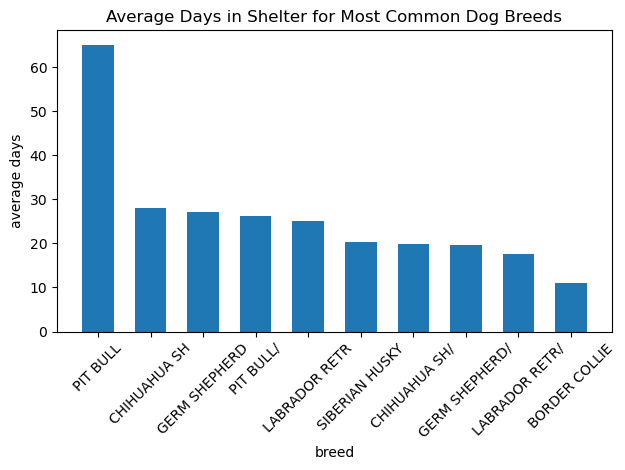

In [19]:
# Plot 1.1: Most Common Dog breeds by average days in shelter
sorted_dog_avg_days = dog_avg_days.sort_values(ascending=False)

# plt.figure(figsize=(12, 6))
plt.bar(dog_avg_days.index, sorted_dog_avg_days.values, width=0.6)
plt.title('Average Days in Shelter for Most Common Dog Breeds')
plt.xlabel('breed')
plt.xticks(rotation=45) 
plt.ylabel('average days')
plt.tight_layout()
plt.savefig('common_dog_breeds_avg_stay.png')
plt.show()

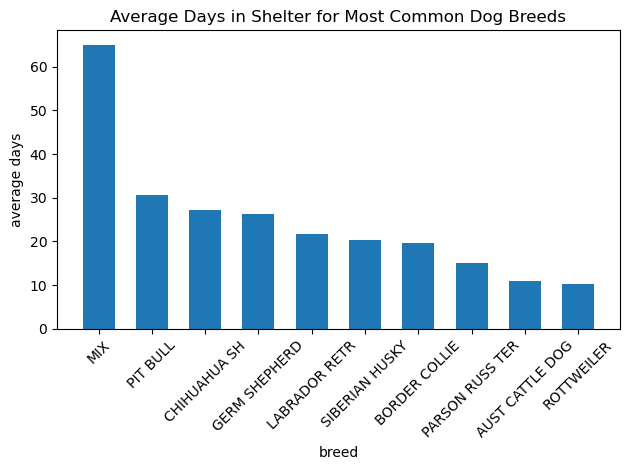

In [20]:
# Plot 1.2: Most Common Dog breeds by average days in shelter, generalizing mixed breeds
sorted_dog_avg_days_mix = dog_avg_days_mix.sort_values(ascending=False)

plt.bar(dog_avg_days_mix.index, sorted_dog_avg_days_mix.values, width=0.6)
plt.title('Average Days in Shelter for Most Common Dog Breeds')
plt.xlabel('breed')
plt.xticks(rotation=45) 
plt.ylabel('average days')
plt.tight_layout()
plt.savefig('common_dog_breeds_avg_stay.png')
plt.show()

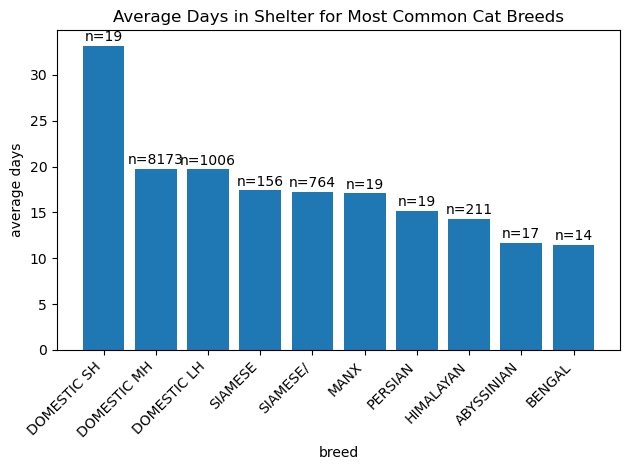

In [21]:
# Plot 2: Most Common Cat breeds by average days in shelter
sorted_cat_avg_days = cat_avg_days.sort_values(ascending=False)

plt.bar(cat_avg_days.index, sorted_cat_avg_days.values)
plt.title('Average Days in Shelter for Most Common Cat Breeds')
plt.xlabel('breed')
plt.xticks(rotation=45, ha='right') 
plt.ylabel('average days')

# adding count labels -  I think it is important to show this in the cat scenario since there's some low 'n' values
for i, breed in enumerate(sorted_cat_avg_days.index):
    plt.text(i, sorted_cat_avg_days[breed] + 0.5, f"n={cat_breed_counts[breed]}", ha='center')

plt.tight_layout()
plt.show()

### Effects of Age and Days in Shelter

TypeError: expected non-empty vector for x

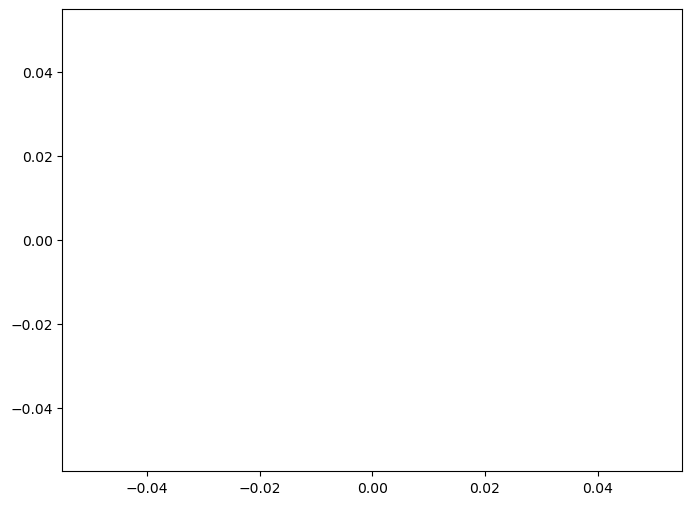

## Data exploration and visualization

Data above looks good(at least we can see the relative primary colors), but doesn't give us the full picture, maybe there's just more black dogs. Let's explore some more. Out of all dogs of a given shade, what's the proportion successfully returned to their owner?

## Conclusions

For now we still need to explore more and improve the notebook. As it stands it's pretty messy but we just wanted to explore as much as we could first and see if we found anything of interest or significance rather than caring too much about form. As we hone down on our areas of interest we will make the data look better and have better descriptions and organization. Lastly exploring the effects of color might be more interesting(given our exploration) so we might pivot to focus more on that.